# Make plots

In [1]:
%load_ext autoreload
%autoreload 2

# Import required modules

In [2]:
import numpy as np, os, sys, glob, tools, flatsky

from pylab import *
#import tools

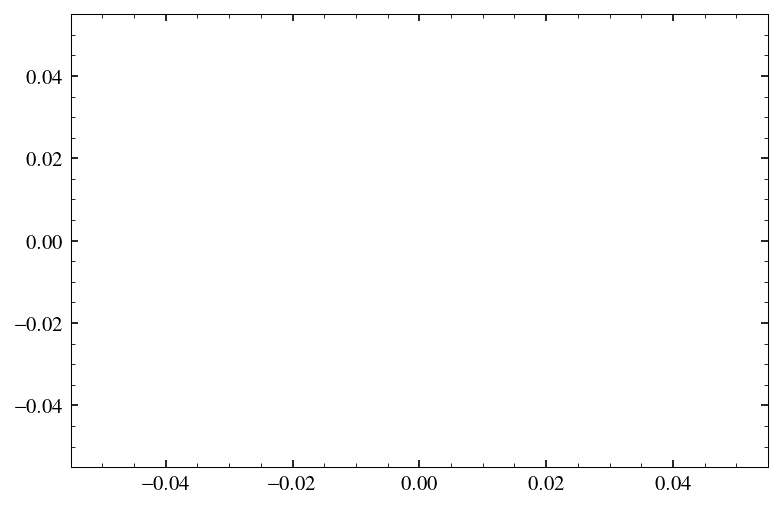

In [4]:
rcParams['figure.dpi'] = 150
rcParams['figure.facecolor'] = 'white'
plot(); show()

In [5]:
def make_ver_shades(ax, yarr, colorval = 'gray', alphaval = 0.05, zorder = -10):
    axhline(0., lw = 0.5, alpha = 0.2)
    delta_y = np.diff(yarr)[0]
    for ycntr, yval in enumerate( yarr ):
        if ycntr%2 == 0:
            y1 = yarr[ycntr] - delta_y/2.
            y2 = yarr[ycntr] + delta_y/2.
            axvspan(y1, y2, color = colorval, alpha = alphaval, zorder = zorder)
    return ax

def format_axis(ax, fx, fy, maxxloc=None, maxyloc = None):
    """
    function to format axis fontsize.


    Parameters
    ----------
    ax: subplot axis.
    fx: fontsize for xaxis.
    fy: fontsize for yaxis.
    maxxloc: total x ticks.
    maxyloc: total y ticks.

    Returns
    -------
    formatted axis "ax".
    """
    for label in ax.get_xticklabels(): label.set_fontsize(fx)
    for label in ax.get_yticklabels(): label.set_fontsize(fy)
    if maxyloc is not None:
        ax.yaxis.set_major_locator(MaxNLocator(nbins=maxxloc))
    if maxxloc is not None:
        ax.xaxis.set_major_locator(MaxNLocator(nbins=maxxloc))
        
    ax.tick_params(which = 'major', direction='in', length=3, width=1.)
    ax.tick_params(which = 'minor', direction='in', length=1., width=1.)

    return ax


def add_subplot_axes(ax,rect,axisbg='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    subax = fig.add_axes([x,y,width,height])#,axisbg=axisbg)
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    #subax.xaxis.set_tick_params(labelsize=x_labelsize)
    #subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax


In [6]:
title_dic = {('ymv', 'ymv'): r'MV', 
                ('ycibfree', 'ycibfree'): r'CIB-min', 
                ('ycibfree', 'ymv'): r'MV x CIB-min',
               }


# tSZ for different cluster masking thresholds

[3.95364385e-18 9.94226373e-19 4.77826690e-19 4.27562782e-19
 3.18141605e-19 2.17119649e-19 1.48463001e-19 1.41404886e-19
 1.14942363e-19] 5.0
[3.92558600e-18 1.24526464e-18 6.04506355e-19 5.33974244e-19
 3.94025122e-19 2.59692601e-19 1.88261159e-19 1.64027218e-19
 1.30725299e-19] 10.0
[5.71240222e-18 1.27975025e-18 5.57614919e-19 3.88159209e-19
 2.88549445e-19 1.99836560e-19 1.38956364e-19 1.35521099e-19
 1.11797830e-19] 5.0
[5.84156463e-18 1.58410736e-18 7.04576010e-19 4.94472013e-19
 3.69943353e-19 2.45587121e-19 1.80637921e-19 1.60643579e-19
 1.28681937e-19] 10.0
[4.92052953e-18 1.15388557e-18 4.97712612e-19 3.90466324e-19
 3.02170907e-19 2.02176026e-19 1.41722932e-19 1.37608518e-19
 1.13142384e-19] 5.0
[4.96733569e-18 1.42821583e-18 6.30297231e-19 4.94529196e-19
 3.79664302e-19 2.46191429e-19 1.82991890e-19 1.62007450e-19
 1.29403867e-19] 10.0


<Figure size 900x600 with 0 Axes>

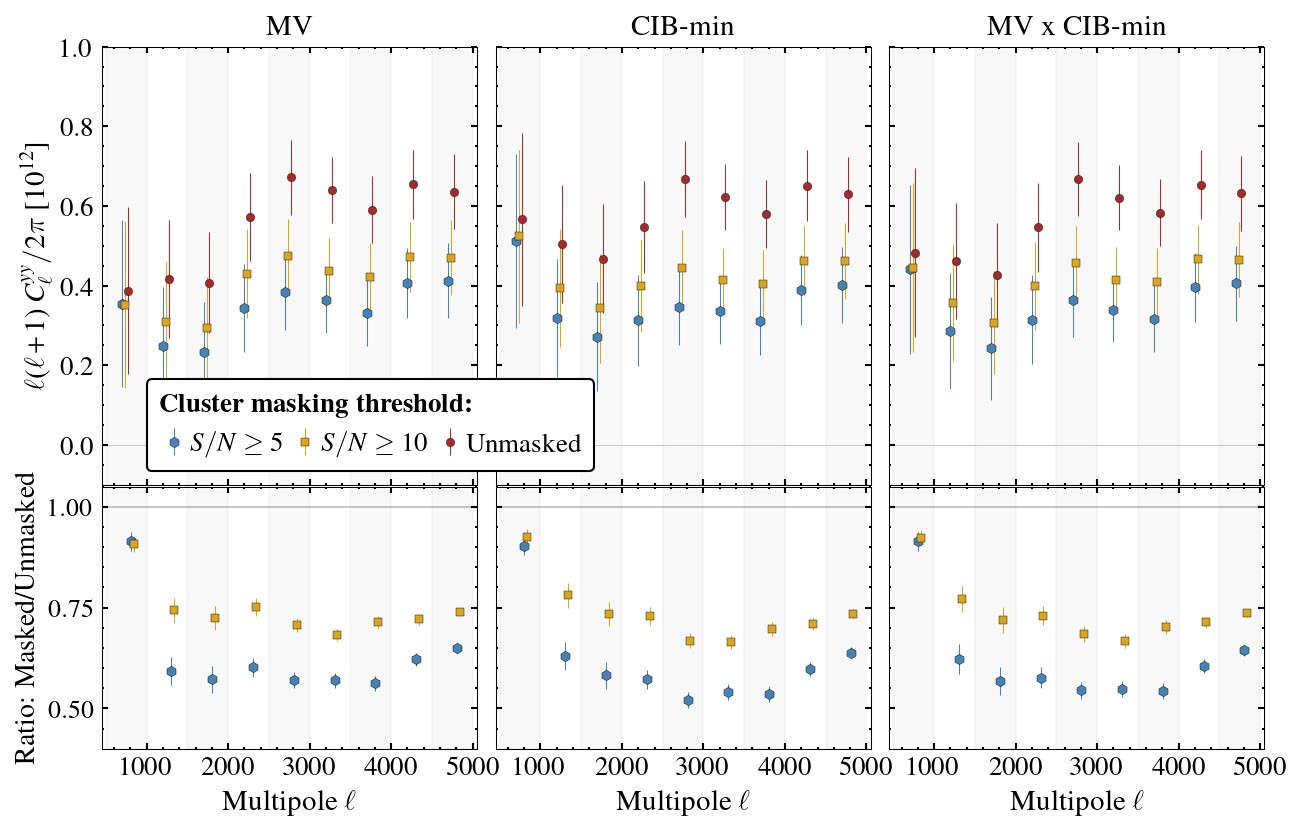

In [15]:
from scipy.optimize import curve_fit

#fname = 'results/100d_tsz_final_estimate.npy'
#fname = 'results/power_spectra_lmin500_lmax7000_deltal250/100d_tsz_final_estimate_beamrc5.1_noslope.npy'
fname = 'results/power_spectra_lmin500_lmax5000_deltal500/100d_tsz_final_estimate_beamrc5.1_noslope.npy'
res_dic = np.load(fname, allow_pickle=True).item()
op_ps_1d_dic = res_dic['op_ps_1d_dic']
debug = False
lmin, lmax, delta_l = 500, 5000, 500

m1_m2_ilc_comb_arr_to_plot = list(res_dic.keys())
also_include_ratio_plot = True
clf()
fsval = 14
if also_include_ratio_plot:
    tr, tc = 8, 3
    rspan = 5
    fig = figure(figsize = (10., 6.2))
else:
    tr, tc = 1, 3
    rspan = 1
    fig = figure(figsize = (10., 4.2))
subplots_adjust(wspace = 0.05, hspace = 0.02)
ymin, ymax = -0.1, 1.#2
xmin, xmax = 450., 5050.
lmax_for_plotting = 5000.
capsizeval = 0. #0.5
mulfac = 1e12
total_sims = 100

#left panel - Final tSZ estimate for all ILC combinations with total error.
mkrval1, msval1 = '', 1.5
mkrval2, msval2 = '.', 1.5
mkrval3, msval3 = '.', 1.5
mkrval4, msval4 = '.', 1.5

ilc_specs_dic = {('ymv', 'ymv'): ['green', r'MV', mkrval1, msval1], 
                ('ycibfree', 'ycibfree'): ['chocolate', r'CIB-min', mkrval2, msval2], 
                ('ycibfree', 'ymv'): ['goldenrod', r'MV x CIB-min', mkrval3, msval3],
               }

#cluster_masking_snr_specs_dic = {4.5: ['steelblue', r'$S/N \ge 4.5$', 'h', 5.], 
cluster_masking_snr_specs_dic = {5.: ['steelblue', r'$S/N \ge 5$', 'h', 5.], 
                10.: ['goldenrod', r'$S/N \ge 10$', 's', 4.], 
                None: ['brown', r'Unmasked', 'o', 4.], 
               }

results_for_cr_dic = {}
for m1m2cntr, m1m2 in enumerate( ilc_specs_dic ):
    ##print(res_dic[m1m2].keys()); sys.exit()
    el_ = res_dic[m1m2]['els']
    cl_data_final = res_dic[m1m2]['data_final']
    cl_data_err = res_dic[m1m2]['data_error']
    data_final_cluster_masked_dic = res_dic[m1m2]['data_final_cluster_masked_dic']
    cl_undesired_comp = res_dic[m1m2]['sim']
    if (1):
        cl_data_final = res_dic[m1m2]['data_final_odd_even_combs_only']
        data_final_cluster_masked_dic = res_dic[m1m2]['data_final_cluster_masked_odd_even_dic']
        ###print(data_final_cluster_masked_dic.keys()); sys.exit()
    ##print(data_final_cluster_masked_dic.keys()); sys.exit()
    
    #20251215 - get the sims with similar masking to get the cov
    ny = nx = 1560
    dx = 0.5
    mapparams = [ny, nx, dx, dx]
    sim_name_for_cov = 'cmb_tsz_ksz_noise_uncorrcib_uncorrrad'
    if (0):
        total_sims = 10
        debug = True

    cov_dic = {}
    for cluster_masking_snr in cluster_masking_snr_specs_dic:
        if cluster_masking_snr is None: continue
        masked_sim_name_for_cov = '%s_cluster_mask_snr_%g' %(sim_name_for_cov, cluster_masking_snr)
        claa_arr, clbb_arr = [], []
        for simno in range( total_sims ):
            curr_claa = op_ps_1d_dic[sim_name_for_cov][simno][0][m1m2][1]
            curr_clbb = op_ps_1d_dic[masked_sim_name_for_cov][simno][0][m1m2][1]
            claa_arr.append( curr_claa )
            clbb_arr.append( curr_clbb )
            
        claa_arr = np.asarray( claa_arr )
        clbb_arr = np.asarray( clbb_arr )        
        
        Caa = np.cov( claa_arr.T )
        Cbb = np.cov( clbb_arr.T )
        Cabratio = tools.get_modified_cov(clbb_arr, claa_arr, operation = 'divide')
        cov_dic[cluster_masking_snr] = Cabratio
        
        if (0):
            claa_mean = np.mean(claa_arr, axis = 0)
            clbb_mean = np.mean(clbb_arr, axis = 0)
            claa_err = np.sqrt( np.diag( Caa ) )
            clbb_err = np.sqrt( np.diag( Cbb ) )
            close('all')
            clf()
            ax = subplot(111)
            dl_fac = el_ * (el_+1)/2/np.pi * 1e12
            errorbar(el_, dl_fac * claa_mean, yerr = dl_fac * claa_err, lw = 2.)
            errorbar(el_, dl_fac * clbb_mean, yerr = dl_fac * clbb_err, lw = 2.)
            
            xlim(0, 5000); ylim(0., 3.)
            show(); 

            clabratio_mean = clbb_mean/claa_mean
            clabratio_err = np.sqrt( np.diag(Cabratio) )
            clabratio_err_v2 = claa_err/claa_mean
            clabratio_err_v3 = cl_data_err/claa_mean
            close('all')
            clf()
            ax = subplot(111)
            dl_fac = el_ * (el_+1)/2/np.pi * 1e12
            errorbar(el_, clabratio_mean, yerr = clabratio_err, lw = 2.)
            errorbar(el_+30, clabratio_mean, yerr = clabratio_err_v2, lw = 2.)
            errorbar(el_+50, clabratio_mean, yerr = clabratio_err_v3, lw = 2.)
            axhline(1., lw = 0.2)
            xlim(0, 5000); ylim(0.4, 1.05)
            show();             
            
            sys.exit()

    linds = np.where(el_<=lmax_for_plotting)[0]
    el_ = el_[linds]
    cl_data_err = cl_data_err[linds]
    dl_fac = el_ * (el_+1)/2/np.pi * mulfac
    
    ##print(tr, tc, m1m2cntr)
    ax = subplot2grid((tr, tc), (0, m1m2cntr), rowspan = rspan)
    xshiftval = -50.
    xshiftdeltaval = 35.
    lwval = 0.5
    curr_masked_plot_dic = {}
    for cluster_masking_snr in cluster_masking_snr_specs_dic:

        if cluster_masking_snr is None:
            curr_cl_data = cl_data_final
        else:
            curr_cl_data = data_final_cluster_masked_dic[cluster_masking_snr]

        curr_cl_data = curr_cl_data[linds]
        curr_masked_plot_dic[cluster_masking_snr] = curr_cl_data

        colorval, labval, mkrval, msval = cluster_masking_snr_specs_dic[cluster_masking_snr]
        errorbar(el_ + xshiftval, dl_fac * curr_cl_data, 
                 yerr = dl_fac * cl_data_err, 
                 color = colorval, mec = 'black', mew = 0.2, 
                 ls ='None', 
                 label = labval, 
                 capsize = capsizeval, 
                 marker = mkrval, ms = msval,
                 elinewidth = lwval, ecolor = colorval, 
                 zorder = 10000,
                )
        xshiftval += xshiftdeltaval


    #shades
    ax = make_ver_shades(ax, el_)
    ax = format_axis(ax, fsval-1, fsval-1)

    if also_include_ratio_plot:
        setp(ax.get_xticklabels(), visible=False)
    else:
        xlabel(r'Multipole $\ell$', fontsize = fsval)
    if m1m2cntr == 0:
        ylabel(r'$\ell(\ell+1)\ C_{\ell}^{yy} / 2\pi$ [$10^{12}$]', fontsize = fsval)
    else:
        setp(ax.get_yticklabels(), visible=False)
    xlim(xmin, xmax); ylim(ymin, ymax)

    #title
    title_val = title_dic[m1m2]
    title(title_val, fontsize = fsval)
    
    if m1m2cntr == 2:
        legfsval, leg_xloc, leg_yloc = fsval, -.65, 0.
        legfsval, leg_xloc, leg_yloc = fsval-1., -.75, 0.
        leg = legend(bbox_to_anchor = (leg_xloc, leg_yloc), loc = 4, 
               fontsize = legfsval, ncol = 4, handletextpad = 0.1, columnspacing = 0.3, 
               handlelength = 1., numpoints = 1, 
               title = r'{\bf Cluster masking threshold:}', title_fontsize = legfsval, 
               framealpha = 1.,
               )
        leg._legend_box.align = "left"
        #legend(bbox_to_anchor = (0.97, 0.82), loc = 4, fontsize = legfsval, ncol = 4, handletextpad = 0.1, columnspacing = 0.3, handlelength = 1., numpoints = 1)
        #ax.legend(handles[inds2], labels[inds2], bbox_to_anchor = (0.97, 0.82), loc = 4, fontsize = legfsval, ncol = len(inds2), handletextpad = 0.2, columnspacing = 0.8, numpoints = 1, framealpha = 1.)#, handlelength = 1.4)

    if also_include_ratio_plot:
        #ratio plot in the bottom now
        ax = subplot2grid((tr, tc), (rspan, m1m2cntr), rowspan = tr-rspan)
        baseline_cluster_masking_snr = None #5 #None
        baseline_cl_data = curr_masked_plot_dic[baseline_cluster_masking_snr]
        for cluster_masking_snr in curr_masked_plot_dic:
            if cluster_masking_snr == baseline_cluster_masking_snr: continue
            curr_cl_data = curr_masked_plot_dic[cluster_masking_snr]
            colorval, labval, mkrval, msval = cluster_masking_snr_specs_dic[cluster_masking_snr]
            #plot( el_, curr_cl_data/baseline_cl_data, color = colorval, ls = '-')
            print(curr_cl_data, cluster_masking_snr)
            curr_ratio = curr_cl_data/baseline_cl_data
            ##curr_ratio_error = cl_data_err/baseline_cl_data
            yminval, ymaxval = 0.4, 1.05
            ylabval = r'Ratio: Masked/Unmasked'

            if cluster_masking_snr is None:
                curr_ratio_error = np.diag( np.sqrt(cov_dic[5.]) )
            else:
                curr_ratio_error = np.diag( np.sqrt(cov_dic[cluster_masking_snr]) )
            
            errorbar(el_ + xshiftval, curr_ratio, 
                     #yerr = dl_fac * cl_data_err, 
                     #yerr = [curr_ratio_with_low_error, curr_ratio_with_high_error], 
                     yerr = curr_ratio_error, 
                     color = colorval, mec = 'black', mew = 0.2, 
                     ls ='None', 
                     label = labval, 
                     capsize = capsizeval, 
                     marker = mkrval, ms = msval,
                     elinewidth = lwval, ecolor = colorval, 
                     zorder = 10000,
                    )
            xshiftval += xshiftdeltaval

        xlabel(r'Multipole $\ell$', fontsize = fsval)
        if m1m2cntr == 0:
            ylabel(ylabval, fontsize = fsval-0.5)
        else:
            setp(ax.get_yticklabels(), visible=False)
        xlim(xmin, xmax); ylim(yminval, ymaxval)
        axhline(1., lw = 0.2)
        ax = make_ver_shades(ax, el_)
        ax = format_axis(ax, fsval-1., fsval-1.5)
        ax.yaxis.set_major_locator(MaxNLocator(nbins=3))

        
plname = 'plots/ymap_spectra_data_cluster_masking'
plname = '%s.pdf' %(plname)
#plname = '%s.png' %(plname)
savefig(plname, dpi = 200.)
show()


In [10]:
sim_name_for_cov

'cmb_tsz_ksz_noise_uncorrcib_uncorrrad'

# Source masked difference estimates

('ymv', 'ymv') 6.0 0.97
('ymv', 'ymv') 10.0 0.8484848484848485
('ymv', 'ymv') 20.0 0.050505050505050504
('ycibfree', 'ycibfree') 6.0 0.93
('ycibfree', 'ycibfree') 10.0 0.7373737373737373
('ycibfree', 'ycibfree') 20.0 0.050505050505050504
('ycibfree', 'ymv') 6.0 0.96
('ycibfree', 'ymv') 10.0 0.6666666666666666
('ycibfree', 'ymv') 20.0 0.06060606060606061
1 3 ('ymv', 'ymv') 0
1 3 ('ycibfree', 'ycibfree') 1
1 3 ('ycibfree', 'ymv') 2


<Figure size 900x600 with 0 Axes>

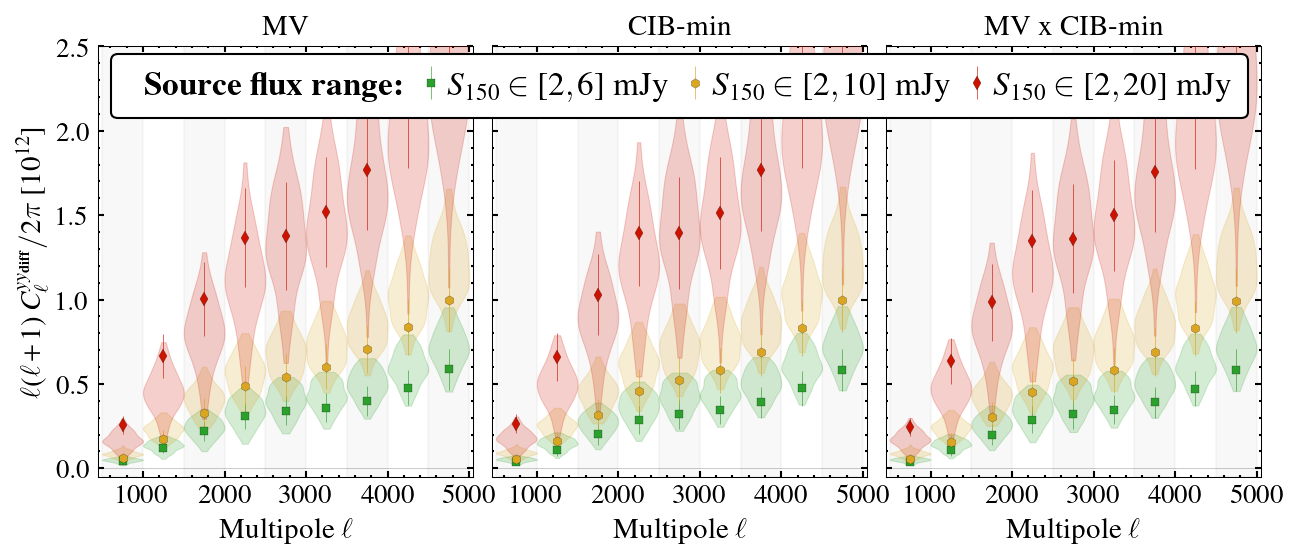

SystemExit: 

In [19]:
def get_good_sim_indices(cl_arr, max_dev = 5., debug = False):
    if debug:
        close('all')
        for cl_ in cl_arr:
            plot(cl_)
        show(); sys.exit()
    median_cl = np.median( cl_arr, axis = 0 )
    std_cl = np.std(cl_arr, axis = 0)
    cl_abs_diff_arr = np.asarray(cl_arr) - median_cl

    bad_sim_inds_all = []
    for elcntr in range( len(median_cl) ):
        bad_sim_inds = np.where( cl_abs_diff_arr[:, elcntr] > max_dev * std_cl[elcntr] )[0]
        bad_sim_inds_all.extend( bad_sim_inds )
        
    bad_sim_inds_all = np.unique( bad_sim_inds_all )
    good_sim_inds = []
    for iii in range( len(cl_arr) ):
        if iii in bad_sim_inds_all: continue
        good_sim_inds.append( iii ) 
    
    return np.asarray( good_sim_inds )
            
    
#from scipy.stats import chi2
#fname1 = 'results/100d_tsz_final_estimate.npy'
extra_str = ''
fd = 'results/power_spectra_lmin500_lmax7000_deltal250/'
if (1):
    fd = 'results/power_spectra_lmin500_lmax5000_deltal500/'
    extra_str = '_beamrc5.1_noslope'
fname = '%s/100d_tsz_final_estimate%s.npy' %(fd, extra_str)
res_dic = np.load(fname, allow_pickle=True).item()

ilc_specs_dic = {
                ('ymv', 'ymv'): ['green', r'MV', mkrval1, msval1], 
                ('ycibfree', 'ycibfree'): ['chocolate', r'CIB-min', mkrval2, msval2], 
                ('ycibfree', 'ymv'): ['goldenrod', r'MV x CIB-min', mkrval3, msval3],
               }

source_masking_specs_dic = {2.: ['steelblue', 'black', r'$S_{150} \ge 2$ mJy', 'o', 4.], 
                6.: ['tab:green', 'black', r'$S_{150} \in [2, 6]$ mJy', 's', 3.5], 
                10.: ['goldenrod', 'black', r'$S_{150} \in [2, 10]$ mJy', 'h', 4.], 
                20.: ['#CD1300', 'black', r'$S_{150} \in [2, 20]$ mJy', 'd', 4.], 
                #20.: ['darkred', 'black', r'$S_{150} \in [2, 20]$ mJy', 'd', 4.], 
               }

"""
source_masking_specs_dic[6][0] = 'navy'
source_masking_specs_dic[10][0] = 'tab:green'
source_masking_specs_dic[20][0] = 'lightcoral'
"""

baseline_source_masking = 2
sim_name_for_sys = 'rad_tweaked_max_tweak_0.2'
#sim_name_for_rad = 'rad'
total_sims = 100
match_tucci_mean = True ##False #True
pl_dic = {}
for source_masking in source_masking_specs_dic:
    ##if source_masking != 20: continue
    if source_masking == baseline_source_masking: continue

    pl_dic[source_masking] = {}
    for m1m2cntr, m1m2 in enumerate( ilc_specs_dic ):            
        el_ = res_dic[m1m2]['els']
        #linds = np.where(el_<=lmax_for_plotting)[0]
        linds = np.arange( len(el_) )
        el_ = res_dic[m1m2]['els'][linds]
        cl_data_source_masking_difference = res_dic[m1m2]['data_final_source_masked_difference_dic'][source_masking][linds]
        
        #get radio sys scatter but remove the baseline from it to get rid of power <2 mJy sources.
        tmpfname = fname.replace('100d_tsz_final_estimate', '100d_tsz_final_estimate_%gmjy' %(source_masking) )
        curr_res_dic = np.load( tmpfname, allow_pickle=True).item()
        cl_sys_arr = []
        """
        baseline_cl_rad_arr = []
        for simno in range(total_sims):
            baseline_cl_rad_arr.append( curr_res_dic['op_ps_1d_dic'][sim_name_for_rad][simno][0][m1m2][1] )
        baseline_cl_rad_arr = np.asarray( baseline_cl_rad_arr )[:,linds]
        baseline_cl_mean = np.mean(baseline_cl_rad_arr, axis = 0)
        """
        for simno in range(total_sims):
            cl_sys_arr.append( curr_res_dic['op_ps_1d_dic'][sim_name_for_sys][simno][0][m1m2][1] )
        cl_sys_arr = np.asarray( cl_sys_arr )
        cl_sys_mean = np.mean(cl_sys_arr, axis = 0)
        cl_sys_arr = np.asarray( cl_sys_arr )[:,linds] - cl_sys_mean
        
        #sims for stat fluctuations
        tmpsimname_for_cov = 'cmb_tsz_ksz_noise_uncorrcib_uncorrrad_rc5.1_noslope_spt3gbeams_compdependent_source_mask_%g_difference_with_fiducial' %(source_masking)
        cl_sim_arr = res_dic[m1m2]['for_consistency_tests'][tmpsimname_for_cov][0][:, linds]

        #refine sims
        good_sim_inds = get_good_sim_indices(cl_sim_arr)
        cl_sim_arr = cl_sim_arr[good_sim_inds]
        cl_sys_arr = cl_sys_arr[good_sim_inds]
        """
        if source_masking == 20: #bad sim
            cl_sim_arr[5] = cl_sim_arr[4]
        elif source_masking == 10: #bad sim
            cl_sim_arr[37] = cl_sim_arr[36]
        """
        
        '''
        cl_rad_analytic_tucci_dn_ds = curr_res_dic['op_ps_1d_dic']['radio_cl_ilc_res_dict'][('ymv', 'ymv')]['tucci'][0.6]['res_ilc'] / 1e12
        cl_rad_analytic_lagache_dn_ds = curr_res_dic['op_ps_1d_dic']['radio_cl_ilc_res_dict']['ymv', 'ymv']['lagache'][0.6]['res_ilc'] / 1e12
        '''
        if m1m2 in curr_res_dic['op_ps_1d_dic']['radio_cl_ilc_res_dict']: 
            cl_rad_analytic_tucci_dn_ds = curr_res_dic['op_ps_1d_dic']['radio_cl_ilc_res_dict'][m1m2]['tucci'][0.6]['res_ilc'] / 1e12
            cl_rad_analytic_lagache_dn_ds = curr_res_dic['op_ps_1d_dic']['radio_cl_ilc_res_dict'][m1m2]['lagache'][0.6]['res_ilc'] / 1e12
        else:
            m1m2_rev = (m1m2[1], m1m2[0])
            cl_rad_analytic_tucci_dn_ds = curr_res_dic['op_ps_1d_dic']['radio_cl_ilc_res_dict'][m1m2_rev]['tucci'][0.6]['res_ilc'] / 1e12
            cl_rad_analytic_lagache_dn_ds = curr_res_dic['op_ps_1d_dic']['radio_cl_ilc_res_dict'][m1m2_rev]['lagache'][0.6]['res_ilc'] / 1e12

        if match_tucci_mean:
            cl_sim_arr = cl_sim_arr - np.mean(cl_sim_arr, axis = 0) + cl_rad_analytic_tucci_dn_ds
        
        #sim total
        #cl_sim_total_arr = cl_sim_arr + cl_sys_arr[:len(cl_sim_arr)]
        cl_sim_total_arr = cl_sim_arr + cl_sys_arr
                
        if (0):            
            close('all')
            for cntr, cl_ in enumerate(cl_sim_arr[25:50]):
                plot(cl_)
            show(); sys.exit()                
        
            which_sim_arr = cl_sim_arr
            #which_sim_arr = baseline_cl_rad_arr
            tmp_cov = np.cov(which_sim_arr.T)
            cl_data_source_masking_difference_err = np.sqrt( np.diag(tmp_cov) )
            dl_fac = el_ * (el_+1)/2/np.pi * 1e12
            clf()
            errorbar(el_, dl_fac * cl_data_source_masking_difference, 
                     yerr = dl_fac * cl_data_source_masking_difference_err, 
                     color = 'black')
            for cl_ in which_sim_arr:
                plot(el_, dl_fac * cl_, alpha = 0.2, lw = 0.2)
            show(); sys.exit()
        
        curr_sim_cov = np.cov( cl_sys_arr.T ) + np.cov(cl_sim_arr.T)
        curr_sim_stat_cov = np.cov(cl_sim_arr.T)        
        ##cl_data_source_masking_difference_err = np.sqrt( np.diag(curr_sim_stat_cov) )
        cl_data_source_masking_difference_err = np.sqrt( np.diag(curr_sim_cov) )
        
        pl_dic[source_masking][m1m2] = [el_, cl_data_source_masking_difference, cl_data_source_masking_difference_err, cl_sim_total_arr, cl_sim_arr, cl_sys_arr, cl_rad_analytic_tucci_dn_ds, cl_rad_analytic_lagache_dn_ds, curr_sim_cov]

if (1): #get statistics now
    for m1m2cntr, m1m2 in enumerate( ilc_specs_dic ):            
        for source_masking in pl_dic:
            ##if source_masking == 6: continue
            el_, cl_data_source_masking_difference, cl_data_source_masking_difference_err, cl_sim_total_arr, cl_sim_arr, cl_sys_arr, cl_rad_analytic_tucci_dn_ds, cl_rad_analytic_lagache_dn_ds, curr_sim_cov = pl_dic[source_masking][m1m2]

            data_chi_sq_val, data_chi_val = tools.get_null_test_chi_sq(cl_data_source_masking_difference, curr_sim_cov)

            sim_chi_sq_arr = []
            sim_chi_arr = []
            for cl_ in cl_sim_total_arr:
                tmp_sim_chi_sq_val, tmp_sim_chi_val = tools.get_null_test_chi_sq(cl_, curr_sim_cov)
                ##print(tmp_sim_chi_sq_val); sys.exit()
                sim_chi_sq_arr.append( tmp_sim_chi_sq_val )
                sim_chi_arr.extend( tmp_sim_chi_val )
            sim_chi_sq_arr = np.asarray( sim_chi_sq_arr )
            #print(sim_chi_sq_arr)

            total_sims = len(sim_chi_sq_arr)
            pvalue_sim_based = float( len(np.where( sim_chi_sq_arr> data_chi_sq_val )[0]) / total_sims )
            print( m1m2, source_masking, pvalue_sim_based ); ##sys.exit()

    ###sys.exit()

clf()
fsval = 14
tr = 1
rspan = 1
fig = figure(figsize = (10., 3.8))
subplots_adjust(wspace = 0.05, hspace = 0.02)
ymin, ymax = -0.1, 1.#2
ymin, ymax = -0.05, 2.5
xmin, xmax = 450., 5050.
lmax_for_plotting = 5000.
capsizeval = 0. #0.5
mulfac = 1e12

for m1m2cntr, m1m2 in enumerate( ilc_specs_dic ):    
    print(tr, tc, m1m2, m1m2cntr)
    ax = subplot2grid((tr, tc), (0, m1m2cntr), rowspan = rspan)
    xshiftval = -100.
    xshiftdeltaval = 50.
    lwval = 0.5

    for source_masking in pl_dic:
        xshiftval = 0.
        el_, cl_data_source_masking_difference, cl_data_source_masking_difference_err, cl_sim_total_arr, cl_sim_arr, cl_sys_arr, cl_rad_analytic_tucci_dn_ds, cl_rad_analytic_lagache_dn_ds, curr_sim_cov = pl_dic[source_masking][m1m2]
        #print(source_masking, el_, cl_data_bundles_source_masking_difference)
        dl_fac = el_ * (el_+1)/2/np.pi * mulfac
        colorval, mec, labval, mkrval, msval = source_masking_specs_dic[source_masking]
        msval, lwval, mew = msval+0.5, 0.3, 0.1
        errorbar(el_ + xshiftval, 
                 dl_fac * cl_data_source_masking_difference, 
                 yerr = dl_fac * cl_data_source_masking_difference_err, 
                 color = colorval, mec = mec, mew = mew, 
                 ls ='None', 
                 label = labval, 
                 capsize = capsizeval, 
                 marker = mkrval, ms = msval,
                 elinewidth = lwval, ecolor = colorval, 
                 zorder = 10000,
                )

        cl_sys_envelope = []
        for elcntr, curr_el in enumerate( el_ ):
            sys_minval, sys_maxval = min(cl_sim_total_arr[:, elcntr]), max(cl_sim_total_arr[:, elcntr])
            cl_sys_envelope.append( [sys_minval, sys_maxval] )
        cl_sys_envelope = np.asarray(cl_sys_envelope)
        
        """
        plot( el_, dl_fac * cl_rad_analytic_lagache_dn_ds, color = colorval, ls = ':')
        plot( el_, dl_fac * cl_rad_analytic_tucci_dn_ds, color = colorval, ls = '-.')
        #show sims
        for cl_ in cl_sim_total_arr:
            plot( el_, dl_fac * cl_, color = colorval, alpha = 0.2, lw = 0.5)
        for cl_ in cl_sim_arr:
            plot( el_, dl_fac * cl_, color = colorval, alpha = 0.2, lw = 0.5)
        for cl_ in cl_sys_arr:
            plot( el_, dl_fac * cl_, color = colorval, alpha = 0.2, lw = 0.5, ls = ':')
        """
        #vioilin
        violin_width = np.diff( el_ )[0]
        for lcntr, curr_l in enumerate(el_):
            cl_curr_lbin = cl_sim_total_arr[:, lcntr]
            
            #face_alphas = np.tile( 0.1, len(cl_curr_lbin))
            #colorarr = np.tile(colorval, len(cl_curr_lbin))
            #colorarr = list(zip(colorarr, face_alphas))

            violins = violinplot([dl_fac[lcntr] * cl_curr_lbin], [curr_l + xshiftval], widths = violin_width, showextrema = False, showmeans=False, points = 100)
            for pc in violins['bodies']: 
                colorval = matplotlib.colors.colorConverter.to_rgba(colorval, alpha=.5)
                pc.set_facecolor(colorval); 
                pc.set_edgecolor(colorval); 
                pc.set_alpha(0.2); 
                pc.set_linestyle('-'); 
                pc.set_linewidth(0.5)
                pc.set_zorder(100)

        xshiftval += xshiftdeltaval


    #shades
    ax = make_ver_shades(ax, el_)
    ax = format_axis(ax, fsval-1, fsval-1)

    xlabel(r'Multipole $\ell$', fontsize = fsval)
    if m1m2cntr == 0:
        ylabel(r'$\ell(\ell+1)\ C_{\ell}^{yy_{\rm {\bf diff}}} / 2\pi$ [$10^{12}$]', fontsize = fsval)
    else:
        setp(ax.get_yticklabels(), visible=False)
    xlim(xmin, xmax); ylim(ymin, ymax)
    ##ylim( -1., 1.)

    #title
    title_val = title_dic[m1m2]
    title(title_val, fontsize = fsval)
    
    if m1m2cntr == 2:
        #legfsval, leg_xloc, leg_yloc = fsval, -0.04, 1.02
        #legfsval, leg_xloc, leg_yloc = fsval, -0.04, -0.1 #1.02
        ###legfsval, leg_loc, leg_xloc, leg_yloc = fsval+2, 1, 1., -0.15 #1.02
        legfsval, leg_loc, leg_xloc, leg_yloc = fsval+2, 1, 1.01, 1.02
        handles, labels = ax.get_legend_handles_labels()
        leg_title = r'{\bf Source flux range:}'
        dummy = [plot([],marker='', ls='')[0]] # Canvas
        handles = dummy + handles
        labels = [leg_title] + labels
        
        leg = ax.legend(
               handles, labels,
               bbox_to_anchor = (leg_xloc, leg_yloc), 
               loc = leg_loc, 
               fontsize = legfsval, 
               ncol = len(pl_dic) + 1, 
               handletextpad = 0.5, columnspacing = 0.8, 
               handlelength = 0., numpoints = 1, 
               #title = leg_title, 
               title_fontsize = legfsval, 
               framealpha = 1.,
               frameon=True,
               )
        leg._legend_box.align = "left"
        leg.set_zorder(20000)
        #legend(bbox_to_anchor = (0.97, 0.82), loc = 4, fontsize = legfsval, ncol = 4, handletextpad = 0.1, columnspacing = 0.3, handlelength = 1., numpoints = 1)
        #ax.legend(handles[inds2], labels[inds2], bbox_to_anchor = (0.97, 0.82), loc = 4, fontsize = legfsval, ncol = len(inds2), handletextpad = 0.2, columnspacing = 0.8, numpoints = 1, framealpha = 1.)#, handlelength = 1.4)

plname = 'plots/ymap_difference_spectra_data_source_masking'
plname = '%s.pdf' %(plname)
###plname = '%s.png' %(plname)
savefig(plname, dpi = 200.)
show()
sys.exit()
        
        

array([9.28742179e-07, 9.13953892e-07, 8.24483550e-07, 6.95514710e-07,
       5.60031199e-07, 4.32623381e-07, 3.77228918e-07, 3.54769632e-07,
       3.39534537e-07])

In [185]:
sim_chi_arr

[]

In [118]:
res_dic['op_ps_1d_dic']['rad'].keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

# tSZ for different source masking thresholds

8 3 ('ymv', 'ymv') 0
8 3 ('ycibfree', 'ycibfree') 1
8 3 ('ycibfree', 'ymv') 2


<Figure size 900x600 with 0 Axes>

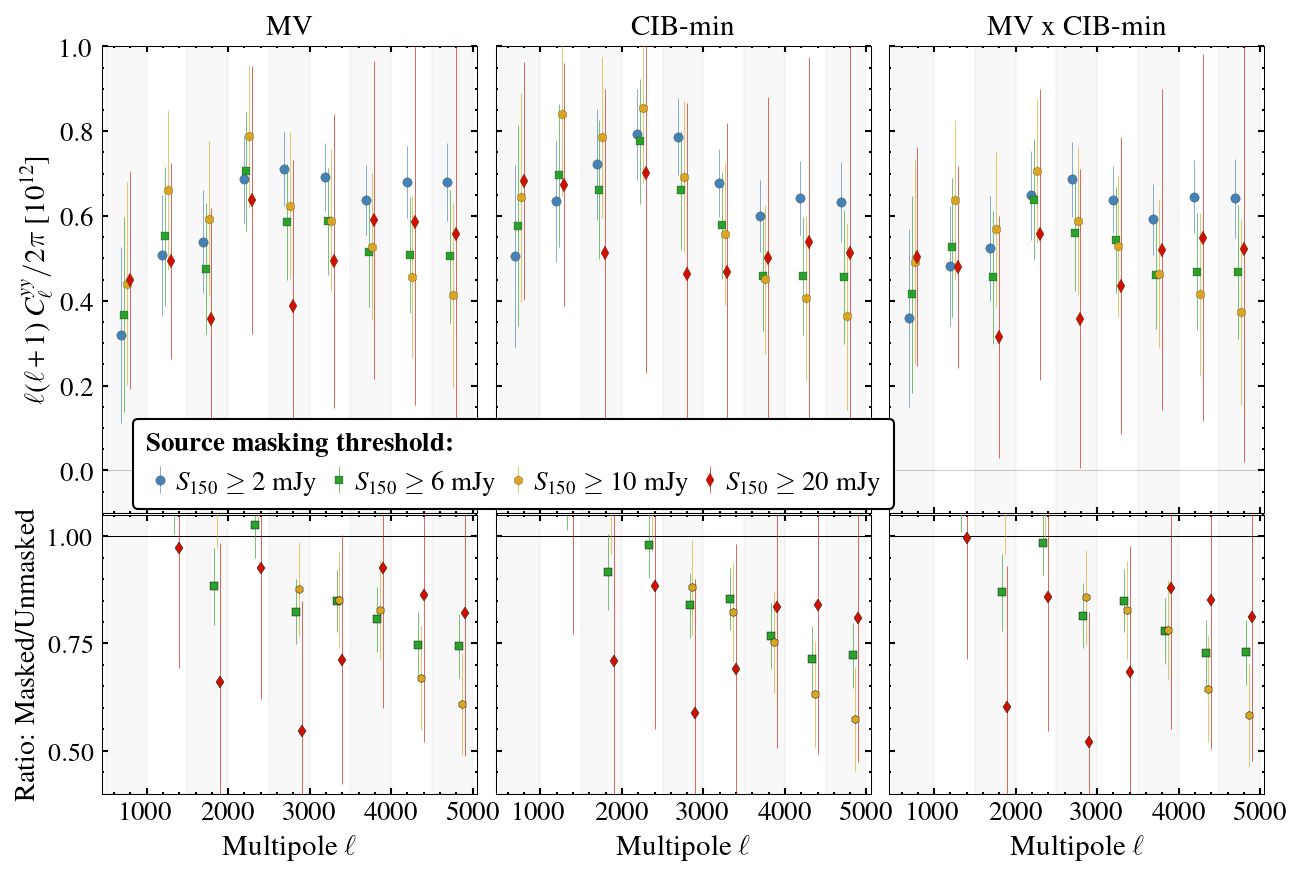

In [75]:
#fname1 = 'results/100d_tsz_final_estimate.npy'
extra_str = ''
fd = 'results/power_spectra_lmin500_lmax7000_deltal250/'
if (1):
    fd = 'results/power_spectra_lmin500_lmax5000_deltal500/'
    extra_str = '_beamrc5.1_noslope'
fname1 = '%s/100d_tsz_final_estimate%s.npy' %(fd, extra_str)
fname2 = '%s/100d_tsz_final_estimate_6mjy%s.npy' %(fd, extra_str)
fname3 = '%s/100d_tsz_final_estimate_10mjy%s.npy' %(fd, extra_str)
fname4 = '%s/100d_tsz_final_estimate_20mjy%s.npy' %(fd, extra_str)

fname_dic = {2: fname1, 6: fname2, 10: fname3, 20: fname4}
#fname_dic = {2: fname1, 6: fname2, 20: fname4}

ilc_specs_dic = {
                ('ymv', 'ymv'): ['green', r'MV', mkrval1, msval1], 
                ('ycibfree', 'ycibfree'): ['chocolate', r'CIB-min', mkrval2, msval2], 
                ('ycibfree', 'ymv'): ['goldenrod', r'MV x CIB-min', mkrval3, msval3],
               }

source_masking_specs_dic = {2.: ['steelblue', 'black', r'$S_{150} \ge 2$ mJy', 'o', 4.], 
                6.: ['tab:green', 'black', r'$S_{150} \ge 6$ mJy', 's', 3.5], 
                10.: ['goldenrod', 'black', r'$S_{150} \ge 10$ mJy', 'h', 4.], 
                20.: ['#CD1300', 'black', r'$S_{150} \ge 20$ mJy', 'd', 4.], 
               }

sim_name_for_cov = 'cmb_tsz_ksz_noise_uncorrcib_uncorrrad'
sim_name_for_sys_cov = 'rad_tweaked_max_tweak_0.2'
total_sims = 100
pl_dic = {}
sim_dic_for_cov = {}
sim_dic_for_sys_cov = {}
sys_cov_dic = {}
for source_masking in fname_dic:
    curr_fname = fname_dic[source_masking]
    curr_res_dic = np.load(curr_fname, allow_pickle=True).item()
    full_sys_cov_dic = curr_res_dic['full_sys_cov_dic']
    full_rad_sys_cov = full_sys_cov_dic['rad_tweaked_max_tweak_0.2']

    #m1_m2_ilc_comb_arr_to_plot = list(curr_res_dic.keys())
    pl_dic[source_masking] = {}
    sim_dic_for_cov[source_masking] = {}
    sys_cov_dic[source_masking] = {}
    for m1m2cntr, m1m2 in enumerate( ilc_specs_dic ):            
        el_ = curr_res_dic[m1m2]['els']
        linds = np.where(el_<=lmax_for_plotting)[0]
        el_ = curr_res_dic[m1m2]['els'][linds]
        cl_data_final = curr_res_dic[m1m2]['data_final'][linds]
        cl_data = curr_res_dic[m1m2]['data'][linds]
        ##print(cl_data_final)
        cl_data_err = curr_res_dic[m1m2]['data_error'][linds]
        cl_sim_arr_for_sub = curr_res_dic[m1m2]['cl_for_sub_arr'][:, linds]
        
        #sims for cov
        cl_arr = []
        cl_sys_arr = []
        for simno in range(total_sims):
            cl_arr.append( curr_res_dic['op_ps_1d_dic'][sim_name_for_cov][simno][0][m1m2][1] )
            cl_sys_arr.append( curr_res_dic['op_ps_1d_dic'][sim_name_for_sys_cov][simno][0][m1m2][1] )
            if (0):##simno == 0 and m1m2cntr == 0:
                print(source_masking, cl_sys_arr[0]); #sys.exit()
        cl_arr = np.asarray( cl_arr )[:,linds]
        cl_sys_arr = np.asarray( cl_sys_arr )[:,linds]
        ###print(cl_sys_arr.shape, cl_arr.shape); sys.exit()

        ##curr_cov = np.cov( cl_arr.T )
        ##cl_data_err = np.sqrt( np.diag(curr_cov) )
        
        reclen = len(linds)
        if m1m2cntr == 0:
            rad_sys_cov = full_rad_sys_cov[:reclen, :reclen]
        elif m1m2cntr == 1:
            rad_sys_cov = full_rad_sys_cov[reclen:2*reclen, reclen:2*reclen]
        elif m1m2cntr == 2:
            rad_sys_cov = full_rad_sys_cov[2*reclen:, 2*reclen:]

        pl_dic[source_masking][m1m2] = [el_, cl_data_final, cl_data, cl_data_err, cl_sim_arr_for_sub]
        sim_dic_for_cov[source_masking][m1m2] = [cl_arr, cl_sys_arr]
        sys_cov_dic[source_masking][m1m2] = rad_sys_cov
##sys.exit()

if (0):
    clf()
    m1m2 = ('ymv', 'ymv')
    dl_fac = el_ * (el_+1)/2/np.pi * 1e12
    for cntr, source_masking in enumerate( fname_dic ):
        el_, cl_data_final, cl_data, cl_data_err, cl_sim_arr_for_sub = pl_dic[source_masking][m1m2]
        curr_rad_sys_cov = sys_cov_dic[source_masking][m1m2] 
        cl_rad_sys_err = np.sqrt( np.diag(curr_rad_sys_cov) )
        errorbar( el_ + 40 * cntr, dl_fac * cl_data_final * 0., yerr = dl_fac * cl_rad_sys_err, ls = 'None', marker = 'o', ms = 3.)
    
    xlim(0., 5000); ylim(-0.5, 0.5)
    show()
    sys.exit()
        

#get combined cov for ratio plots
baseline_source_masking = 2.0
cov_dic = {}
for m1m2cntr, m1m2 in enumerate( ilc_specs_dic ):
    cl_aa_arr, cl_aa_sys_arr = sim_dic_for_cov[baseline_source_masking][m1m2]
    cov_dic[m1m2] = {}
    for source_masking in fname_dic:
        cl_bb_arr, cl_bb_sys_arr = sim_dic_for_cov[source_masking][m1m2]
        Cabratio = tools.get_modified_cov(cl_bb_arr, cl_aa_arr, operation = 'divide')
        Cabsysratio = tools.get_modified_cov(cl_bb_sys_arr, cl_aa_sys_arr, operation = 'divide')
        ##print(Cabsysratio); sys.exit()
        cov_dic[m1m2][source_masking] = Cabratio + Cabsysratio

clf()
fsval = 14
also_include_ratio_plot = True #False ##True #False
if also_include_ratio_plot:
    tr = 8
    rspan = 5
    fig = figure(figsize = (10., 6.6))
else:
    tr = 1
    rspan = 1
    fig = figure(figsize = (10., 3.8))
subplots_adjust(wspace = 0.05, hspace = 0.02)
ymin, ymax = -0.1, 1.#2
#ymin, ymax = -0.1, 4.
xmin, xmax = 450., 5050.
lmax_for_plotting = 5000.
capsizeval = 0. #0.5
mulfac = 1e12

single_panel = False #True

for m1m2cntr, m1m2 in enumerate( ilc_specs_dic ):    
    print(tr, tc, m1m2, m1m2cntr)
    ax = subplot2grid((tr, tc), (0, m1m2cntr), rowspan = rspan)
    if single_panel:  
        close('all')
        clf()
        ax = subplot(111)
    xshiftval = -60.
    xshiftdeltaval = 35.
    lwval = 0.5
    curr_masked_plot_dic = {}
    for source_masking in pl_dic:

        el_, curr_cl_data_final, curr_cl_data, curr_cl_data_err, curr_cl_sim_arr_for_sub = pl_dic[source_masking][m1m2]
        dl_fac = el_ * (el_+1)/2/np.pi * mulfac
        curr_masked_plot_dic[source_masking] = [dl_fac * curr_cl_data_final, dl_fac * curr_cl_data_err]
        colorval, mec, labval, mkrval, msval = source_masking_specs_dic[source_masking]
        msval, lwval, mew = msval+0.5, 0.3, 0.1
        errorbar(el_ + xshiftval, dl_fac * curr_cl_data_final, 
                 yerr = dl_fac * curr_cl_data_err, 
                 color = colorval, mec = mec, mew = mew, 
                 ls ='None', 
                 label = labval, 
                 capsize = capsizeval, 
                 marker = mkrval, ms = msval,
                 elinewidth = lwval, ecolor = colorval, 
                 zorder = 10000,
                )
        """
        #show sims
        for cl_ in curr_cl_sim_arr_for_sub:
            plot( el_, dl_fac * cl_, color = colorval, alpha = 0.5, lw = 0.5)
        """
        xshiftval += xshiftdeltaval


    #shades
    ax = make_ver_shades(ax, el_)
    ax = format_axis(ax, fsval-1, fsval-1)

    if also_include_ratio_plot:
        setp(ax.get_xticklabels(), visible=False)
    else:
        xlabel(r'Multipole $\ell$', fontsize = fsval)
    if m1m2cntr == 0:
        ylabel(r'$\ell(\ell+1)\ C_{\ell}^{yy} / 2\pi$ [$10^{12}$]', fontsize = fsval)
    else:
        setp(ax.get_yticklabels(), visible=False)
    xlim(xmin, xmax); ylim(ymin, ymax)

    #title
    title_val = title_dic[m1m2]
    title(title_val, fontsize = fsval)
    
    if m1m2cntr == 2 and not single_panel:
        legfsval, leg_xloc, leg_yloc = fsval, 0.2, -0.02
        legfsval, leg_xloc, leg_yloc = fsval-1, 0.05, -0.02
        leg = legend(bbox_to_anchor = (leg_xloc, leg_yloc), loc = 4, 
               fontsize = legfsval, ncol = len(pl_dic), handletextpad = 0.1, columnspacing = 0.3, 
               handlelength = 1., numpoints = 1, 
               title = r'{\bf Source masking threshold:}', title_fontsize = legfsval, 
               framealpha = 1.,
               )
        leg._legend_box.align = "left"
        #legend(bbox_to_anchor = (0.97, 0.82), loc = 4, fontsize = legfsval, ncol = 4, handletextpad = 0.1, columnspacing = 0.3, handlelength = 1., numpoints = 1)
        #ax.legend(handles[inds2], labels[inds2], bbox_to_anchor = (0.97, 0.82), loc = 4, fontsize = legfsval, ncol = len(inds2), handletextpad = 0.2, columnspacing = 0.8, numpoints = 1, framealpha = 1.)#, handlelength = 1.4)

    if also_include_ratio_plot:
        #ratio plot in the bottom now
        ax = subplot2grid((tr, tc), (rspan, m1m2cntr), rowspan = tr-rspan)
        baseline_masking = 2.0
        baseline_cl_data, baseline_cl_data_err = curr_masked_plot_dic[baseline_masking]
        for source_masking in curr_masked_plot_dic:
            if source_masking == baseline_masking: continue
            curr_cl_data, curr_cl_data_err = curr_masked_plot_dic[source_masking]
            curr_cl_data_err = np.sqrt( np.diag( cov_dic[m1m2][source_masking] ) )
            colorval, mec, labval, mkrval, msval = source_masking_specs_dic[source_masking]
            errorbar(el_ + xshiftval, curr_cl_data/baseline_cl_data, 
            #errorbar(el_ + xshiftval, curr_cl_data-baseline_cl_data, 
                     yerr = curr_cl_data_err, 
                     color = colorval, mec = mec, mew = 0.2, 
                     ls ='None', 
                     label = labval, 
                     capsize = capsizeval, 
                     marker = mkrval, ms = msval,
                     elinewidth = lwval, ecolor = colorval, 
                     zorder = 10000,
                    )
            xshiftval += xshiftdeltaval

        xlabel(r'Multipole $\ell$', fontsize = fsval)
        if m1m2cntr == 0:
            ylabel(r'Ratio: Masked/Unmasked', fontsize = fsval-0.5)
        else:
            setp(ax.get_yticklabels(), visible=False)
        xlim(xmin, xmax); 
        axhline(1., lw = 0.5); ylim(0.4, 1.05)
        #axhline(0., lw = 0.5); ylim(-0.5, 0.5)
        ax = make_ver_shades(ax, el_)
        ax = format_axis(ax, fsval-1., fsval-1.5)
        ax.yaxis.set_major_locator(MaxNLocator(nbins=3))
    if single_panel: show()
# plname = 'plots/ymap_spectra_data_source_masking'
# plname = '%s.pdf' %(plname)
# #plname = '%s.png' %(plname)
# savefig(plname, dpi = 200.)
show()


In [124]:
curr_res_dic[m1m2]['cl_for_sub_arr'].shape

(25, 9)

/Users/sraghunathan/Research/SPTpol/analysis/git/tSZ_2pt_SPT_SPIRE/flatsky.py:376: ComplexWarning: Casting complex values to real discards the imaginary part
  vals[ib] = np.sum(imrad) / total


NameError: name 'cl_a_over_b_sim' is not defined

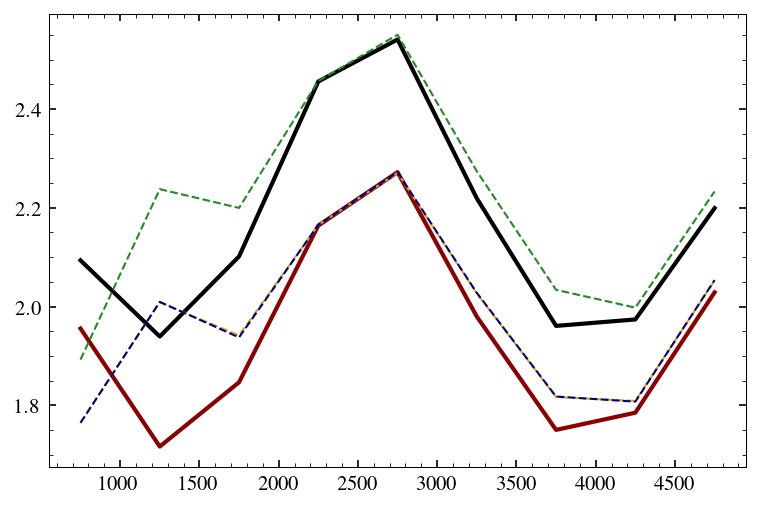

In [9]:
from scipy.optimize import curve_fit

#fname = 'results/100d_tsz_final_estimate.npy'
#fname = 'results/power_spectra_lmin500_lmax7000_deltal250/100d_tsz_final_estimate_beamrc5.1_noslope.npy'
fname = 'results/power_spectra_lmin500_lmax5000_deltal500/100d_tsz_final_estimate_beamrc5.1_noslope.npy'
res_dic = np.load(fname, allow_pickle=True).item()
op_ps_1d_dic = res_dic['op_ps_1d_dic']
debug = False
lmin, lmax, delta_l = 500, 5000, 500

m1_m2_ilc_comb_arr_to_plot = list(res_dic.keys())
also_include_ratio_plot = True
clf()
fsval = 14
if also_include_ratio_plot:
    tr, tc = 8, 3
    rspan = 5
    fig = figure(figsize = (10., 6.2))
else:
    tr, tc = 1, 3
    rspan = 1
    fig = figure(figsize = (10., 4.2))
subplots_adjust(wspace = 0.05, hspace = 0.02)
ymin, ymax = -0.1, 1.#2
xmin, xmax = 450., 5050.
lmax_for_plotting = 5000.
capsizeval = 0. #0.5
mulfac = 1e12

#left panel - Final tSZ estimate for all ILC combinations with total error.
mkrval1, msval1 = '', 1.5
mkrval2, msval2 = '.', 1.5
mkrval3, msval3 = '.', 1.5
mkrval4, msval4 = '.', 1.5

ilc_specs_dic = {('ymv', 'ymv'): ['green', r'MV', mkrval1, msval1], 
                ('ycibfree', 'ycibfree'): ['chocolate', r'CIB-min', mkrval2, msval2], 
                ('ycibfree', 'ymv'): ['goldenrod', r'MV x CIB-min', mkrval3, msval3],
               }

#cluster_masking_snr_specs_dic = {4.5: ['steelblue', r'$S/N \ge 4.5$', 'h', 5.], 
cluster_masking_snr_specs_dic = {5.: ['steelblue', r'$S/N \ge 5$', 'h', 5.], 
                10.: ['goldenrod', r'$S/N \ge 10$', 's', 4.], 
                None: ['brown', r'Unmasked', 'o', 4.], 
               }

results_for_cr_dic = {}
for m1m2cntr, m1m2 in enumerate( ilc_specs_dic ):
    if m1m2 not in m1_m2_ilc_comb_arr_to_plot: continue
    ##print(res_dic[m1m2].keys()); sys.exit()
    el_ = res_dic[m1m2]['els']
    cl_data_final = res_dic[m1m2]['data_final']
    cl_data_err = res_dic[m1m2]['data_error']
    data_final_cluster_masked_dic = res_dic[m1m2]['data_final_cluster_masked_dic']
    ##print(data_final_cluster_masked_dic.keys()); sys.exit()
    
    #20251215 - get the sims with similar masking to get the cov
    ny = nx = 1560
    dx = 0.5
    mapparams = [ny, nx, dx, dx]
    sim_name_for_cov = 'cmb_tsz_ksz_noise_uncorrcib_uncorrrad'
    if (1):
        total_sims = 10
        debug = True
    for cluster_masking_snr in cluster_masking_snr_specs_dic:
        claa_arr, clbb_arr = [], []
        for simno in range( total_sims ):
            curr_sim_fid_cl = op_ps_1d_dic[sim_name_for_cov][simno][0][m1m2][1]
            masked_sim_name_for_cov = '%s_cluster_mask_snr_%g' %(sim_name_for_cov, cluster_masking_snr)
            curr_sim_masked_cl = op_ps_1d_dic[masked_sim_name_for_cov][simno][0][m1m2][1]
            claa_arr.append( curr_sim_fid_cl )
            clbb_arr.append( curr_sim_masked_cl )
        claa = np.mean(claa_arr, axis = 0)
        clbb = np.mean(clbb_arr, axis = 0)
        clab = np.copy( clbb )        
            
        #generate sims now
        #sim_a_arr, sim_b_arr = [], []
        #sim_ab_ratio_arr = []
        claa_sim_arr, clbb_sim_arr, clab_sim_arr = [], [], []
        cl_a_over_b_sim_arr = []
        for simno in range( total_sims ):
            sim_a, sim_b, sim_c = flatsky.make_gaussian_realisation(mapparams, el_, claa, cl2 = clbb, cl12 = clab)
            #sim_a_arr.append( sim_a )
            #sim_b_arr.append( sim_b )
            tmpels, claa_sim = flatsky.map2cl(mapparams, sim_a, binsize = delta_l, minbin = lmin, maxbin = lmax)
            tmpels, clbb_sim = flatsky.map2cl(mapparams, sim_b, binsize = delta_l, minbin = lmin, maxbin = lmax)
            cl_a_over_b_sim_arr.append( claa_sim/clbb_sim )
            
            if total_sims<=10 and debug:
                tmpbinsize = 500
                tmpels, claa_sim = flatsky.map2cl(mapparams, sim_a, binsize = tmpbinsize, minbin = 500, maxbin = 5000)
                tmpels, clbb_sim = flatsky.map2cl(mapparams, sim_b, binsize = tmpbinsize, minbin = 500, maxbin = 5000)
                tmpels, clab_sim = flatsky.map2cl(mapparams, sim_a, flatskymap2 = sim_b, binsize = tmpbinsize, minbin = 500, maxbin = 5000)
                claa_sim_arr.append( claa_sim )
                clbb_sim_arr.append( clbb_sim )
                clab_sim_arr.append( clab_sim )
                

        if total_sims<=10 and debug:
            claa_sim_mean = np.mean(claa_sim_arr, axis = 0)
            clbb_sim_mean = np.mean(clbb_sim_arr, axis = 0)
            clab_sim_mean = np.mean(clab_sim_arr, axis = 0)
            cl_a_over_b_sim_mean = np.mean(cl_a_over_b_sim_arr, axis = 0)
            close('all')
            clf()
            ax = subplot(111)
            dl_fac = el_ * (el_+1)/2/np.pi * 1e12
            tmp_dl_fac = tmpels * (tmpels+2)/2/np.pi * 1e12
            plot(el_, dl_fac * claa, lw = 2.)
            plot(el_, dl_fac * clbb, lw = 2.)
            
            plot(tmpels, tmp_dl_fac * claa_sim_mean, ls = '--')
            plot(tmpels, tmp_dl_fac * clbb_sim_mean, ls = '--')
            plot(tmpels, tmp_dl_fac * clab_sim_mean, ls = '--')
            plot(tmpels, tmp_dl_fac * cl_a_over_b_sim, ls = '-.', color = 'peru', lw = 3.)
            
            
            xlim(0, 5000); ylim(0., 2.5)
            show(); sys.exit()
            

    linds = np.where(el_<=lmax_for_plotting)[0]
    el_ = el_[linds]
    cl_data_err = cl_data_err[linds]
    dl_fac = el_ * (el_+1)/2/np.pi * mulfac
    
    ##print(tr, tc, m1m2cntr)
    ax = subplot2grid((tr, tc), (0, m1m2cntr), rowspan = rspan)
    xshiftval = -50.
    xshiftdeltaval = 35.
    lwval = 0.5
    curr_masked_plot_dic = {}
    for cluster_masking_snr in cluster_masking_snr_specs_dic:

        if cluster_masking_snr is None:
            curr_cl_data = cl_data_final
        else:
            curr_cl_data = data_final_cluster_masked_dic[cluster_masking_snr]

        curr_cl_data = curr_cl_data[linds]
        curr_masked_plot_dic[cluster_masking_snr] = curr_cl_data

        colorval, labval, mkrval, msval = cluster_masking_snr_specs_dic[cluster_masking_snr]
        errorbar(el_ + xshiftval, dl_fac * curr_cl_data, 
                 yerr = dl_fac * cl_data_err, 
                 color = colorval, mec = 'black', mew = 0.2, 
                 ls ='None', 
                 label = labval, 
                 capsize = capsizeval, 
                 marker = mkrval, ms = msval,
                 elinewidth = lwval, ecolor = colorval, 
                 zorder = 10000,
                )
        xshiftval += xshiftdeltaval


    #shades
    ax = make_ver_shades(ax, el_)
    ax = format_axis(ax, fsval-1, fsval-1)

    if also_include_ratio_plot:
        setp(ax.get_xticklabels(), visible=False)
    else:
        xlabel(r'Multipole $\ell$', fontsize = fsval)
    if m1m2cntr == 0:
        ylabel(r'$\ell(\ell+1)\ C_{\ell}^{yy} / 2\pi$ [$10^{12}$]', fontsize = fsval)
    else:
        setp(ax.get_yticklabels(), visible=False)
    xlim(xmin, xmax); ylim(ymin, ymax)

    #title
    title_val = title_dic[m1m2]
    title(title_val, fontsize = fsval)
    
    if m1m2cntr == 2:
        legfsval, leg_xloc, leg_yloc = fsval, -.65, 0.
        legfsval, leg_xloc, leg_yloc = fsval-1., -.75, 0.
        leg = legend(bbox_to_anchor = (leg_xloc, leg_yloc), loc = 4, 
               fontsize = legfsval, ncol = 4, handletextpad = 0.1, columnspacing = 0.3, 
               handlelength = 1., numpoints = 1, 
               title = r'{\bf Cluster masking threshold:}', title_fontsize = legfsval, 
               framealpha = 1.,
               )
        leg._legend_box.align = "left"
        #legend(bbox_to_anchor = (0.97, 0.82), loc = 4, fontsize = legfsval, ncol = 4, handletextpad = 0.1, columnspacing = 0.3, handlelength = 1., numpoints = 1)
        #ax.legend(handles[inds2], labels[inds2], bbox_to_anchor = (0.97, 0.82), loc = 4, fontsize = legfsval, ncol = len(inds2), handletextpad = 0.2, columnspacing = 0.8, numpoints = 1, framealpha = 1.)#, handlelength = 1.4)

    if also_include_ratio_plot:
        #ratio plot in the bottom now
        ax = subplot2grid((tr, tc), (rspan, m1m2cntr), rowspan = tr-rspan)
        baseline_cluster_masking_snr = None
        baseline_cl_data = curr_masked_plot_dic[baseline_cluster_masking_snr]
        for cluster_masking_snr in curr_masked_plot_dic:
            if cluster_masking_snr == baseline_cluster_masking_snr: continue
            curr_cl_data = curr_masked_plot_dic[cluster_masking_snr]
            colorval, labval, mkrval, msval = cluster_masking_snr_specs_dic[cluster_masking_snr]
            #plot( el_, curr_cl_data/baseline_cl_data, color = colorval, ls = '-')
            curr_ratio = curr_cl_data/baseline_cl_data
            curr_ratio_error = cl_data_err/baseline_cl_data
            yminval, ymaxval = 0.4, 1.05
            ylabval = r'Ratio: Masked/Unmasked'
            """
            if (0):
                ####curr_ratio_error = dl_fac * cl_data_err
                curr_ratio_with_low_error = (curr_cl_data - cl_data_err)/(baseline_cl_data - cl_data_err)
                curr_ratio_with_high_error = (curr_cl_data + cl_data_err)/(baseline_cl_data + cl_data_err)
                if (0):
                    curr_ratio = 1./curr_ratio
                    curr_ratio_with_low_error = 1./curr_ratio_with_low_error
                    curr_ratio_with_high_error = 1./curr_ratio_with_high_error
                    yminval, ymaxval = 0.95, 2.
                    ylabval = r'Ratio: Unmasked/masked'
                curr_ratio_error = (curr_ratio_with_low_error-curr_ratio_with_high_error)
            """
            """
            if (0): #fit for tilt
                x, y = el_, curr_ratio
                m, c = np.polyfit(x, y, 1)
                print(m, c)
                yfit = m * x + c
                plot(el_, yfit, color = colorval, lw = 2.)
            if (1):
                linds = np.where( el_>=2500)[0]
                x, y, yerr = el_[linds], curr_ratio[linds], curr_ratio_error[linds]
                def linear_function(x, slope, intercept):
                    return slope * x + intercept
                
                popt, pcov = curve_fit(linear_function, x, y, sigma=yerr)
                print(popt)
                yfit = linear_function(x, popt[0], popt[1])
                plot(el_[linds], yfit, color = colorval, lw = 2.)
            if (0):
                x, y, yerr = el_, curr_ratio, curr_ratio_error
                def fit_function(x, a, b, c, x_norm = 3000): return a + b * (x/x_norm)**-c
                #def fit_function(x, a, b, c): return a + b * (x)**-c
                
                popt, pcov = curve_fit(linear_function, x, y, sigma=yerr)
                yfit = fit_function(x, popt[0], popt[1], popt[1])
                #print(yfit)
                plot(el_, yfit, color = colorval, lw = 2.)

            axhline(np.mean(curr_ratio), color = colorval, )
            if (1):
                tmpinds = np.where( (el_>=2800) & (el_<=3200) )[0]
                #tmpinds = np.argmin( abs(el_-3000) )
                print(cluster_masking_snr, el_[tmpinds], np.mean(el_[tmpinds]), 
                      np.mean(1/curr_ratio[tmpinds]), '+/-', np.mean(curr_ratio_error[tmpinds]),
                      )##; sys.exit()
            """
            errorbar(el_ + xshiftval, curr_ratio, 
                     #yerr = dl_fac * cl_data_err, 
                     #yerr = [curr_ratio_with_low_error, curr_ratio_with_high_error], 
                     yerr = curr_ratio_error, 
                     color = colorval, mec = 'black', mew = 0.2, 
                     ls ='None', 
                     label = labval, 
                     capsize = capsizeval, 
                     marker = mkrval, ms = msval,
                     elinewidth = lwval, ecolor = colorval, 
                     zorder = 10000,
                    )
            xshiftval += xshiftdeltaval

        xlabel(r'Multipole $\ell$', fontsize = fsval)
        if m1m2cntr == 0:
            ylabel(ylabval, fontsize = fsval-0.5)
        else:
            setp(ax.get_yticklabels(), visible=False)
        xlim(xmin, xmax); ylim(yminval, ymaxval)
        axhline(1., lw = 0.2)
        ax = make_ver_shades(ax, el_)
        ax = format_axis(ax, fsval-1., fsval-1.5)
        ax.yaxis.set_major_locator(MaxNLocator(nbins=3))

        
plname = 'plots/ymap_spectra_data_cluster_masking'
plname = '%s.pdf' %(plname)
#plname = '%s.png' %(plname)
###savefig(plname, dpi = 200.)
show()
